In [7]:
import random
import time

import matplotlib.pyplot as plt
import numpy as np
from torch.utils import data
from torch.utils.tensorboard import SummaryWriter  # 导入SummaryWriter

import grid_env
from model import *
from render import *

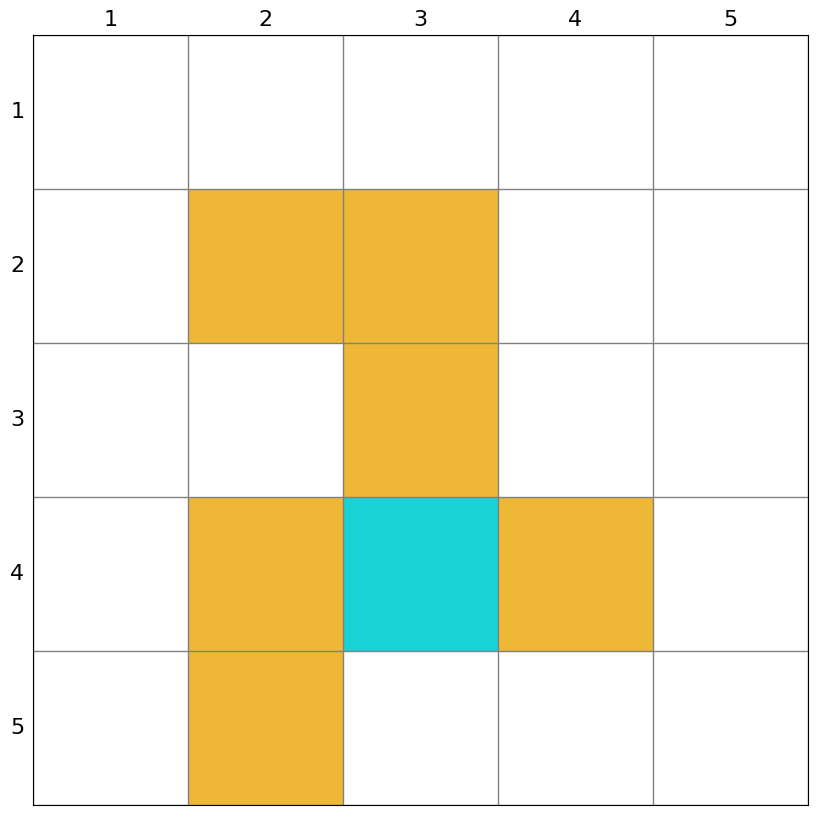

In [8]:
env = grid_env.GridEnv(size=5, target=[2, 3], forbidden=[[1, 1],[2, 1],[2, 2],[1, 3],[3, 3],[1, 4]], render_mode='')

In [9]:
def expected_sarsa1(env, alpha=0.1, epsilon=1, num_episodes=1500, gamma = 0.8):
    """
    Expected SARSA 算法实现，用于估计状态-动作值 (Q 值) 并改进策略。

    参数：
    env - 环境对象，包含状态空间、动作空间以及相关的环境操作
    alpha - 学习率，控制每次更新Q值时的步长
    epsilon - epsilon-greedy 策略的探索概率
    num_episodes - 训练的回合数
    gamma - 折扣因子，用于权衡短期奖励与长期奖励

    返回：
    policy - 经过训练的策略矩阵
    """
    state_space_size = env.size ** 2
    action_space_size = env.action_space_size

    # 初始化策略为均匀分布
    policy = np.ones((state_space_size, action_space_size)) / action_space_size

    # 初始化Q值为零矩阵
    qvalue = np.zeros((state_space_size, action_space_size))
    init_num = num_episodes
    qvalue_list = [qvalue, qvalue + 1]
    episode_index_list = []
    reward_list = []# 存储每个回合的总奖励
    length_list = []# 存储每个回合的长度（步数）
    while num_episodes > 0:
        if epsilon>0.1:
            epsilon-=0.01
        episode_index_list.append(init_num - num_episodes)
        done = False
        env.reset()
        next_state = 0
        total_rewards = 0
        episode_length = 0
        num_episodes -= 1
        print(np.linalg.norm(qvalue_list[-1] - qvalue_list[-2], ord=1), num_episodes)
        while not done:
            state = next_state
            action = np.random.choice(np.arange(action_space_size),
                                          p=policy[state])
            _, reward, done, _, _ = env.step(action)
            next_state = env.pos2state(env.agent_location)
            expected_qvalue = 0
            episode_length += 1
            total_rewards += reward
            for next_action in range(action_space_size):
                expected_qvalue += qvalue[next_state, next_action] * policy[next_state, next_action]
            target = reward + gamma * expected_qvalue
            error = qvalue[state, action] - target
            qvalue[state, action] = qvalue[state, action] - alpha * error
            qvalue_star = qvalue[state].max()
            action_star = qvalue[state].tolist().index(qvalue_star)
            for a in range(action_space_size):
                if a == action_star:
                    policy[state, a] = 1 - (
                            action_space_size - 1) / action_space_size * epsilon
                else:
                    policy[state, a] = 1 / action_space_size * epsilon

        qvalue_list.append(qvalue.copy())
        reward_list.append(total_rewards)
        length_list.append(episode_length)
    fig = plt.figure(figsize=(10, 10))
    env.render_.add_subplot_to_fig(fig=fig, x=episode_index_list, y=reward_list, subplot_position=211,
                                            xlabel='episode_index', ylabel='total_reward')
    env.render_.add_subplot_to_fig(fig=fig, x=episode_index_list, y=length_list, subplot_position=212,
                                            xlabel='episode_index', ylabel='total_length')
    fig.show()
    return policy

25.0 1499
52.3731041150443 1498
1.7395319795345197 1497
2.82311302125868 1496
4.989941197237448 1495
7.270853649029748 1494
4.766429566713153 1493
1.5786837729350203 1492
5.913638948817625 1491
2.974461681666935 1490
1.01974699303346 1489
6.85082523771816 1488
0.8106913748628923 1487
0.9275956745685021 1486
2.5552744822406805 1485
3.3180783947723764 1484
2.7107051632863426 1483
3.2006285941421204 1482
2.19871136790677 1481
6.824716828424798 1480
3.371703448033054 1479
6.3132674960997495 1478
4.9849793261815645 1477
1.7859472061051724 1476
0.8508121214634918 1475
1.1398896346318113 1474
1.1252712865113867 1473
1.8822660947109346 1472
2.38032575898119 1471
0.4187167973986625 1470
3.4791509742796434 1469
5.895397089415541 1468
1.7682474680075617 1467
2.1929338440475905 1466
1.6223007299988852 1465
1.1467512154728237 1464
1.3708227197524328 1463
2.4878329962901504 1462
2.3361177539791673 1461
2.6488969312703325 1460
1.47088649854143 1459
0.627727857418783 1458
0.8225386844194564 1457
1.754

C:\Users\Jiangwang\AppData\Local\Temp\ipykernel_1748\2148934473.py:70: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


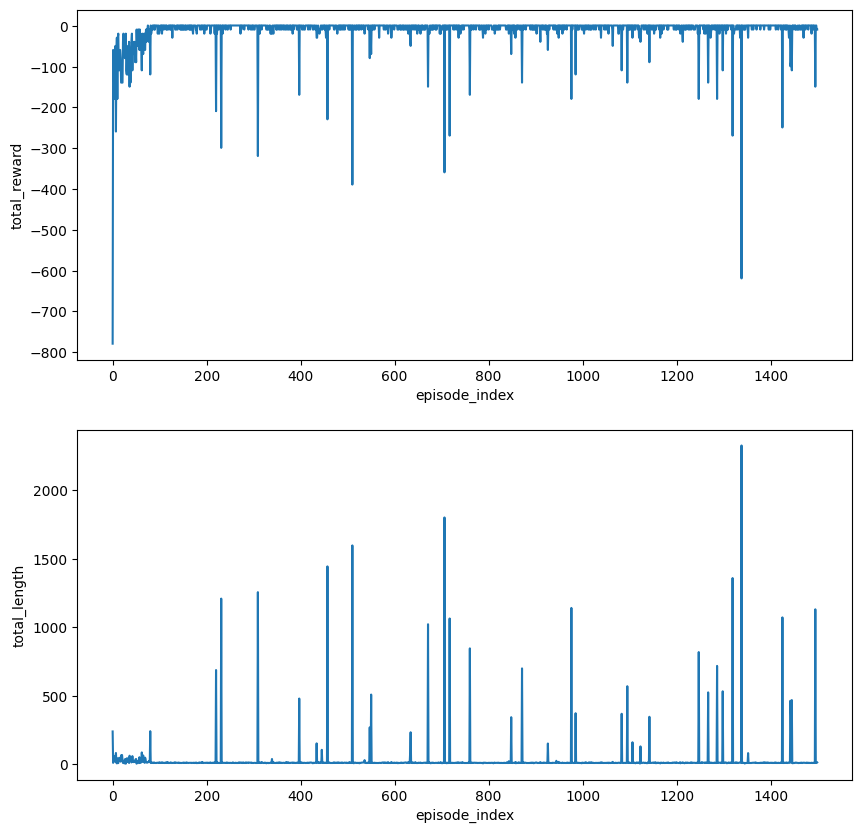

In [10]:
policy = expected_sarsa1(env)
print(policy)

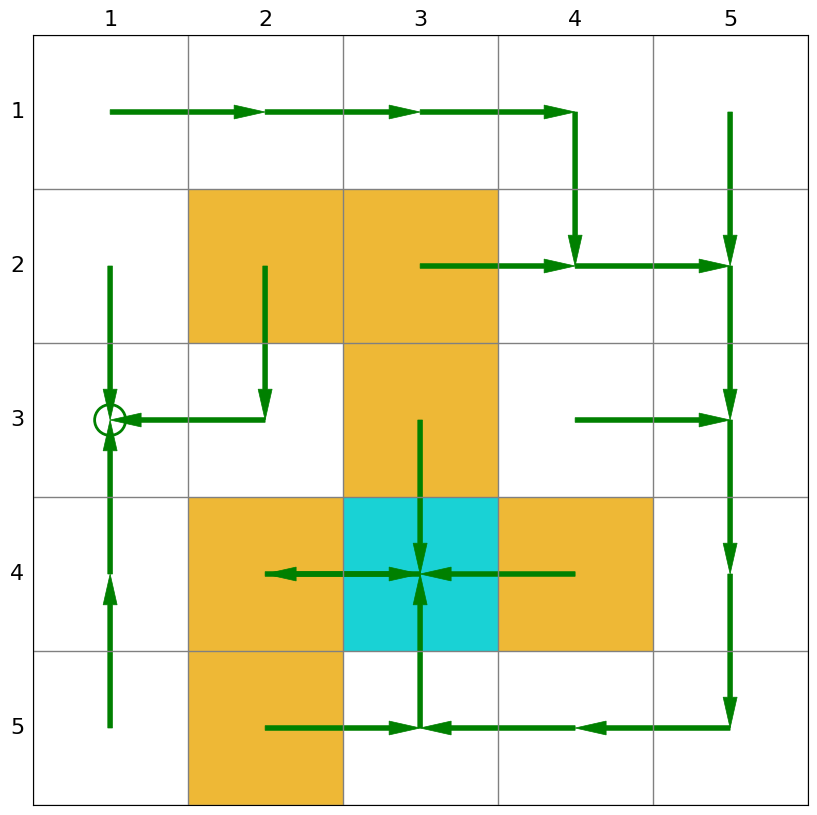

In [11]:
# 定义动作对应的方向
action_to_direction = {
    0: np.array([-1, 0]),
    1: np.array([0, 1]),
    2: np.array([1, 0]),
    3: np.array([0, -1]),
    4: np.array([0, 0]),
}
render = Render(target=[2, 3], forbidden=[[1, 1],[2, 1],[2, 2],[1, 3],[3, 3],[1, 4]], size=5)
# 绘制每个状态的最优动作
for state in range(policy.shape[0]):
    # 计算状态在网格中的位置
    row, col = env.state2pos(state)
    
    # 找出当前状态下的最优动作
    best_action = np.argmax(policy[state])
    
    # 根据最优动作绘制箭头
    render.draw_action(pos=[row, col], toward=action_to_direction[best_action])

# 显示结果
render.show_frame()